In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize, warp, rescale
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr30k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
alexnet, cnn_model = mmsom.create_cnn_model()

In [4]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr30k_sentence/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
print(len(test_captions))
print(len(test_captions.drop_duplicates(['caption', 'fname'])))
test_captions.head()

5000
5000


vector_0  vector_1  vector_2  vector_3  vector_4  vector_5  vector_6  \
0  0.014374  0.006487 -0.042115 -0.058029  0.036493 -0.012606  0.017660   
1  0.007769 -0.003761 -0.044688 -0.053584  0.013478 -0.007328  0.021183   
2  0.006500  0.017829 -0.014951 -0.023215  0.033409 -0.005390  0.003044   
3  0.030906  0.020851 -0.019435 -0.021689  0.018127 -0.031066 -0.005033   
4 -0.013861 -0.020805 -0.050314 -0.027570  0.036581 -0.009254  0.000782   

   vector_7  vector_8  vector_9  \
0 -0.003536 -0.027002  0.672071   
1  0.002066  0.025666  0.595120   
2  0.007378  0.003112  0.596866   
3  0.037364  0.030092  0.649415   
4 -0.014671  0.032486  0.612675   

                         ...                          vector_293  vector_294  \
0                        ...                           -0.007479   -0.054052   
1                        ...                           -0.024272   -0.073400   
2                        ...                           -0.006982   -0.041270   
3                        ...                           -0.004811   -0.069716   
4                        ...                            0.018629   -0.035312   

   vector_295  vector_296  vector_297  vector_298  vector_299  caption_id  \
0    0.024768    0.009723   -0.004624   -0.029254    0.039362           0   
1    0.019545    0.017496   -0.037832   -0.014197   -0.044824           1   
2   -0.024136   -0.012247   -0.011367   -0.056075   -0.035509           2   
3   -0.011067    0.005232   -0.017120   -0.014194   -0.015815           3   
4    0.013951   -0.031299   -0.035975   -0.000521   -0.025029           4   

                                             caption  \
0  Workers are busy erecting scaffolding on the s...   
1  Four men are working with scaffolding , two ha...   
2  A four man construction crew is assembling sca...   
3  Four men next to campaign signs build red scaf...   
4          four worker are constructing a scaffold .   

                                               fname  
0  /data/master_thesis/Flickr30k_Dataset/23845072...  
1  /data/master_thesis/Flickr30k_Dataset/23845072...  
2  /data/master_thesis/Flickr30k_Dataset/23845072...  
3  /data/master_thesis/Flickr30k_Dataset/23845072...  
4  /data/master_thesis/Flickr30k_Dataset/23845072...  

[5 rows x 303 columns]

In [5]:
train_captions_fname = Path('/data/master_thesis/image_retrieval_flickr30k_sentence/train_captions.csv')
train_captions = pd.read_csv(train_captions_fname)
print(len(train_captions))
print(len(train_captions.drop_duplicates(['caption', 'fname'])))
train_captions.head()

153915
153881


vector_0  vector_1  vector_2  vector_3  vector_4  vector_5  vector_6  \
0  0.033022  0.008471 -0.039966 -0.021005  0.048444  0.003836 -0.010112   
1  0.045454 -0.000545 -0.024641 -0.013727  0.080810  0.020618  0.003581   
2  0.056178 -0.000578 -0.052185 -0.042640  0.068031  0.015169  0.034897   
3  0.029597  0.044986 -0.028097 -0.022828  0.074255 -0.008158 -0.003222   
4  0.050583  0.029003 -0.047122 -0.046272  0.069065  0.009673  0.008268   

   vector_7  vector_8  vector_9  \
0  0.006818 -0.038747  0.554227   
1 -0.025218 -0.032026  0.447763   
2 -0.007751 -0.013928  0.523588   
3 -0.024114 -0.024307  0.576296   
4  0.005114 -0.016680  0.561876   

                         ...                          vector_293  vector_294  \
0                        ...                           -0.060637   -0.026378   
1                        ...                           -0.059129   -0.015910   
2                        ...                           -0.052858   -0.028069   
3                        ...                           -0.079915   -0.043619   
4                        ...                           -0.044745   -0.021172   

   vector_295  vector_296  vector_297  vector_298  vector_299  caption_id  \
0    0.009119    0.067394    0.025777    0.005968    0.052843           0   
1   -0.013466    0.029065    0.025692    0.047835    0.027678           1   
2   -0.018227    0.039273    0.015586    0.055053   -0.010203           2   
3    0.009312    0.036968    0.005346    0.026218    0.022750           3   
4   -0.019614    0.032827    0.051004    0.018560   -0.000829           4   

                                             caption  \
0  A downhill skier with a backpack , on a backgr...   
1  A skier in a red jacket and yellow backpack sk...   
2  Person with two ski poles skiing down a snowy ...   
3  A man in orange is skiing down a snow-covered ...   
4                A skier going down the snowy hill .   

                                               fname  
0  /data/master_thesis/Flickr30k_Dataset/14720539...  
1  /data/master_thesis/Flickr30k_Dataset/14720539...  
2  /data/master_thesis/Flickr30k_Dataset/14720539...  
3  /data/master_thesis/Flickr30k_Dataset/14720539...  
4  /data/master_thesis/Flickr30k_Dataset/14720539...  

[5 rows x 303 columns]

In [6]:
len(train_captions.fname.value_counts())

30783

In [7]:
vec2img_train_fname = Path('vec2img_train.csv')
if vec2img_train_fname.exists():
    vec2img_train = pd.read_csv(vec2img_train_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_train = []
    for fname in tqdmn(train_captions.fname):
        vec2img_train.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_train = pd.DataFrame(
        vec2img_train, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_train = vec2img_train.set_index('fname')
    vec2img_train.to_csv(vec2img_train_fname)
vec2img_train.head()

vector_0  vector_1  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0  3.961813   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0  3.961813   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0  3.961813   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0  3.961813   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0  3.961813   

                                                    vector_2  vector_3  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   

                                                    vector_4  vector_5  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/147205399...   3.66285   0.43217   
/data/master_thesis/Flickr30k_Dataset/147205399...   3.66285   0.43217   
/data/master_thesis/Flickr30k_Dataset/147205399...   3.66285   0.43217   
/data/master_thesis/Flickr30k_Dataset/147205399...   3.66285   0.43217   
/data/master_thesis/Flickr30k_Dataset/147205399...   3.66285   0.43217   

                                                    vector_6  vector_7  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/147205399...  0.856566       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...  0.856566       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...  0.856566       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...  0.856566       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...  0.856566       0.0   

                                                    vector_8  vector_9  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...       0.0       0.0   

                                                       ...       vector_4086  \
fname                                                  ...                     
/data/master_thesis/Flickr30k_Dataset/147205399...     ...          2.564675   
/data/master_thesis/Flickr30k_Dataset/147205399...     ...          2.564675   
/data/master_thesis/Flickr30k_Dataset/147205399...     ...          2.564675   
/data/master_thesis/Flickr30k_Dataset/147205399...     ...          2.564675   
/data/master_thesis/Flickr30k_Dataset/147205399...     ...          2.564675   

                                                    vector_4087  vector_4088  \
fname                                                                          
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0          0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0          0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0          0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0          0.0   
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0          0.0   

                                                    vector_4089  vector_4090  \
fname                                                                          
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0      0.37629   
/data/master_thesis/Flickr30k_Dataset/147205399...          0.0      0.37629   
/data/master_th

In [8]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

In [9]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

vector_0  vector_1  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/676337024...       0.0  1.766636   
/data/master_thesis/Flickr30k_Dataset/607561473...       0.0  2.138351   
/data/master_thesis/Flickr30k_Dataset/463184070...       0.0  2.634080   
/data/master_thesis/Flickr30k_Dataset/851566221...       0.0  0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...       0.0  0.000000   

                                                    vector_2  vector_3  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/676337024...       0.0  1.666934   
/data/master_thesis/Flickr30k_Dataset/607561473...       0.0  0.025989   
/data/master_thesis/Flickr30k_Dataset/463184070...       0.0  0.900209   
/data/master_thesis/Flickr30k_Dataset/851566221...       0.0  0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...       0.0  0.000000   

                                                    vector_4  vector_5  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/676337024...  0.000000  0.256413   
/data/master_thesis/Flickr30k_Dataset/607561473...  0.000000  0.000000   
/data/master_thesis/Flickr30k_Dataset/463184070...  0.000000  0.000000   
/data/master_thesis/Flickr30k_Dataset/851566221...  6.141291  0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...  4.199216  0.000000   

                                                    vector_6  vector_7  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/676337024...  1.911942  0.000000   
/data/master_thesis/Flickr30k_Dataset/607561473...  0.509377  0.780878   
/data/master_thesis/Flickr30k_Dataset/463184070...  0.000000  0.000000   
/data/master_thesis/Flickr30k_Dataset/851566221...  0.234200  0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...  0.039170  0.000000   

                                                    vector_8  vector_9  \
fname                                                                    
/data/master_thesis/Flickr30k_Dataset/676337024...       0.0  0.000000   
/data/master_thesis/Flickr30k_Dataset/607561473...       0.0  0.000000   
/data/master_thesis/Flickr30k_Dataset/463184070...       0.0  0.990532   
/data/master_thesis/Flickr30k_Dataset/851566221...       0.0  0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...       0.0  0.000000   

                                                       ...       vector_4086  \
fname                                                  ...                     
/data/master_thesis/Flickr30k_Dataset/676337024...     ...          0.440866   
/data/master_thesis/Flickr30k_Dataset/607561473...     ...          0.850299   
/data/master_thesis/Flickr30k_Dataset/463184070...     ...          0.394699   
/data/master_thesis/Flickr30k_Dataset/851566221...     ...          0.000000   
/data/master_thesis/Flickr30k_Dataset/255073988...     ...          0.000000   

                                                    vector_4087  vector_4088  \
fname                                                                          
/data/master_thesis/Flickr30k_Dataset/676337024...          0.0     0.000000   
/data/master_thesis/Flickr30k_Dataset/607561473...          0.0     0.000000   
/data/master_thesis/Flickr30k_Dataset/463184070...          0.0     0.000000   
/data/master_thesis/Flickr30k_Dataset/851566221...          0.0     0.776137   
/data/master_thesis/Flickr30k_Dataset/255073988...          0.0     0.000000   

                                                    vector_4089  vector_4090  \
fname                                                                          
/data/master_thesis/Flickr30k_Dataset/676337024...     0.000000     1.354725   
/data/master_thesis/Flickr30k_Dataset/607561473...     0.000134     0.000000   
/data/master_th

In [10]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(model.som_model.codebook.reshape(10000, 4396))

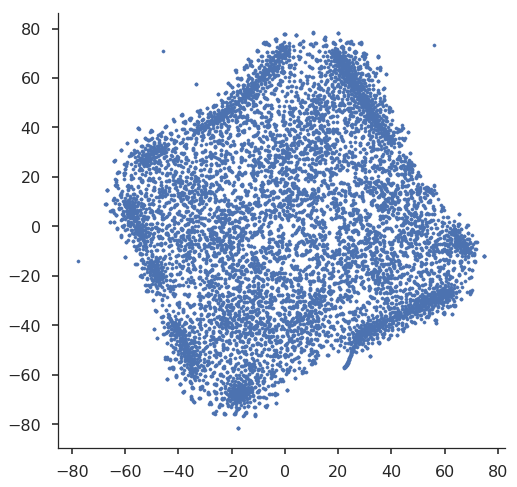

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(*projection.T, s=10)
sns.despine()

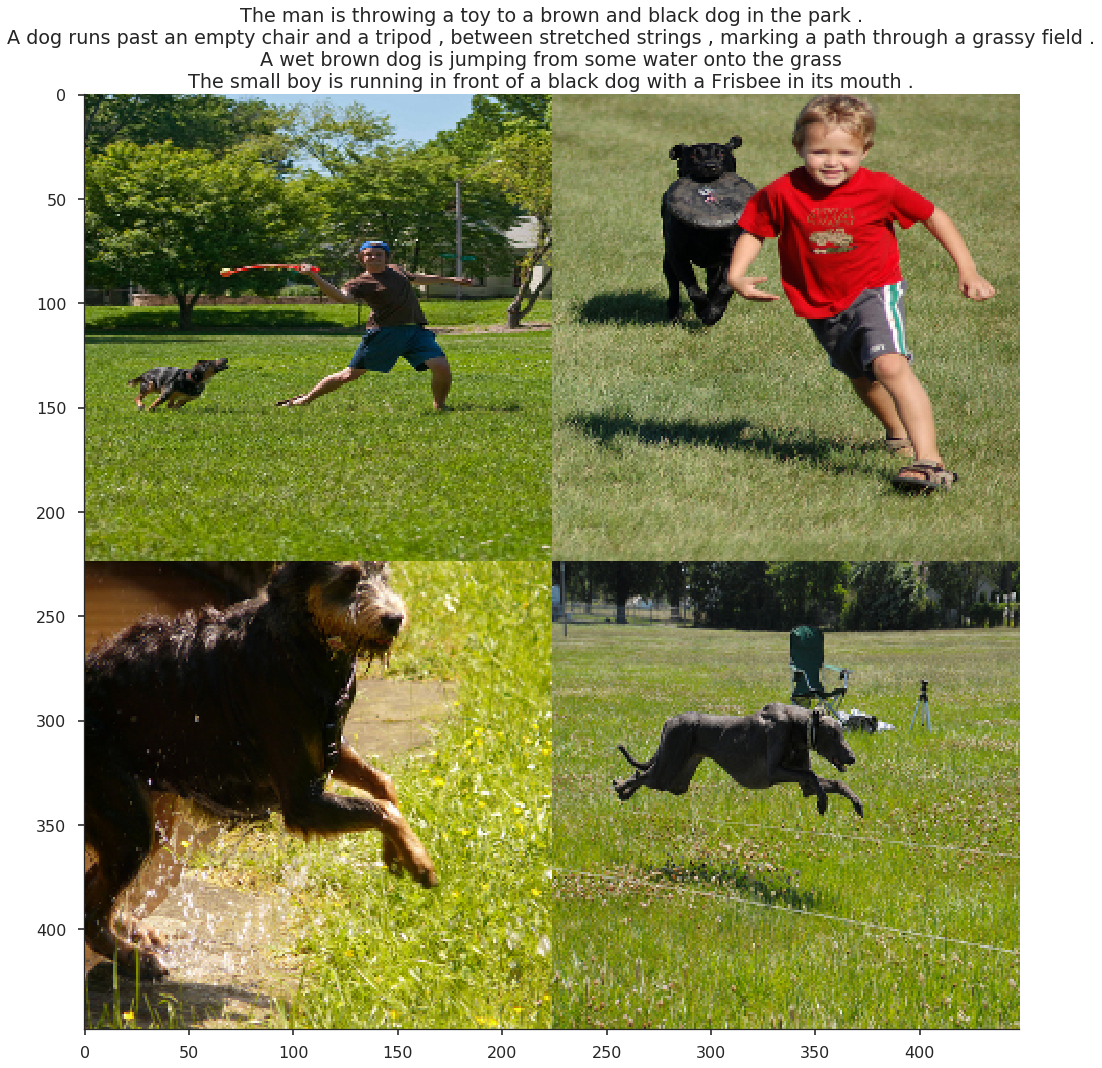

In [10]:
ax = plt.figure(figsize=(16, 16)).gca()
knn_ids = model.get_knn_images(doc='dog', k=4, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
fig_array = np.ones((2, 2, 224, 224, 3))
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    fig_array[i//2, i%2] = img

fig_array = fig_array.transpose(0, 2, 1, 3, 4).reshape(224*2, 224*2, 3)
ax.set_title('\n'.join(test_captions.loc[test_captions.fname.isin(knn.astype(str)), 'caption'].iloc[::5]))
ax.imshow(fig_array)
sns.despine()
plt.tight_layout()

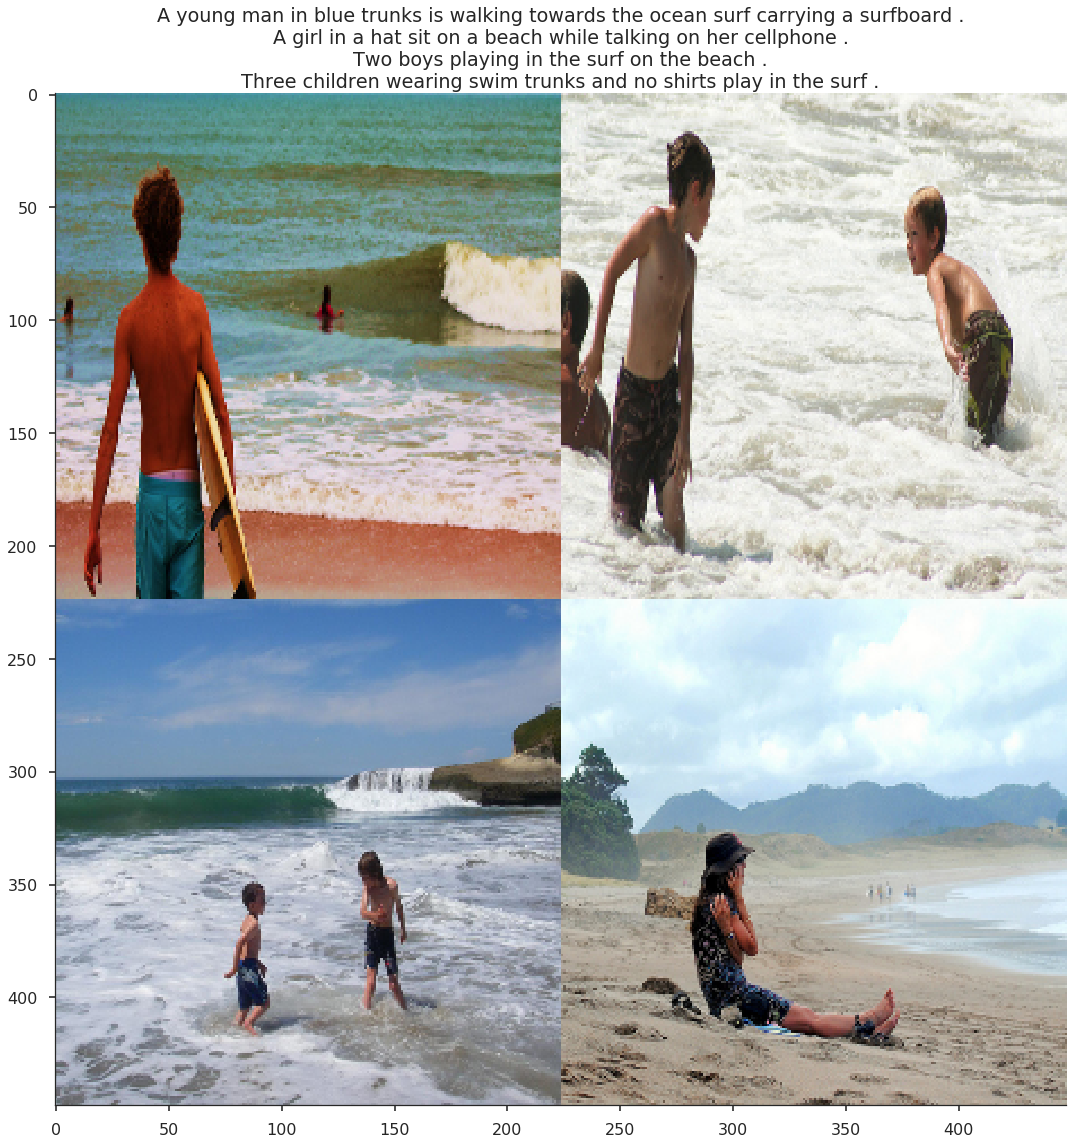

In [11]:
ax = plt.figure(figsize=(16, 16)).gca()
knn_ids = model.get_knn_images(doc='water', k=4, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
fig_array = np.ones((2, 2, 224, 224, 3))
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    fig_array[i//2, i%2] = img

fig_array = fig_array.transpose(0, 2, 1, 3, 4).reshape(224*2, 224*2, 3)
ax.set_title('\n'.join(test_captions.loc[test_captions.fname.isin(knn.astype(str)), 'caption'].iloc[1::5]))
ax.imshow(fig_array)
sns.despine()
plt.tight_layout()

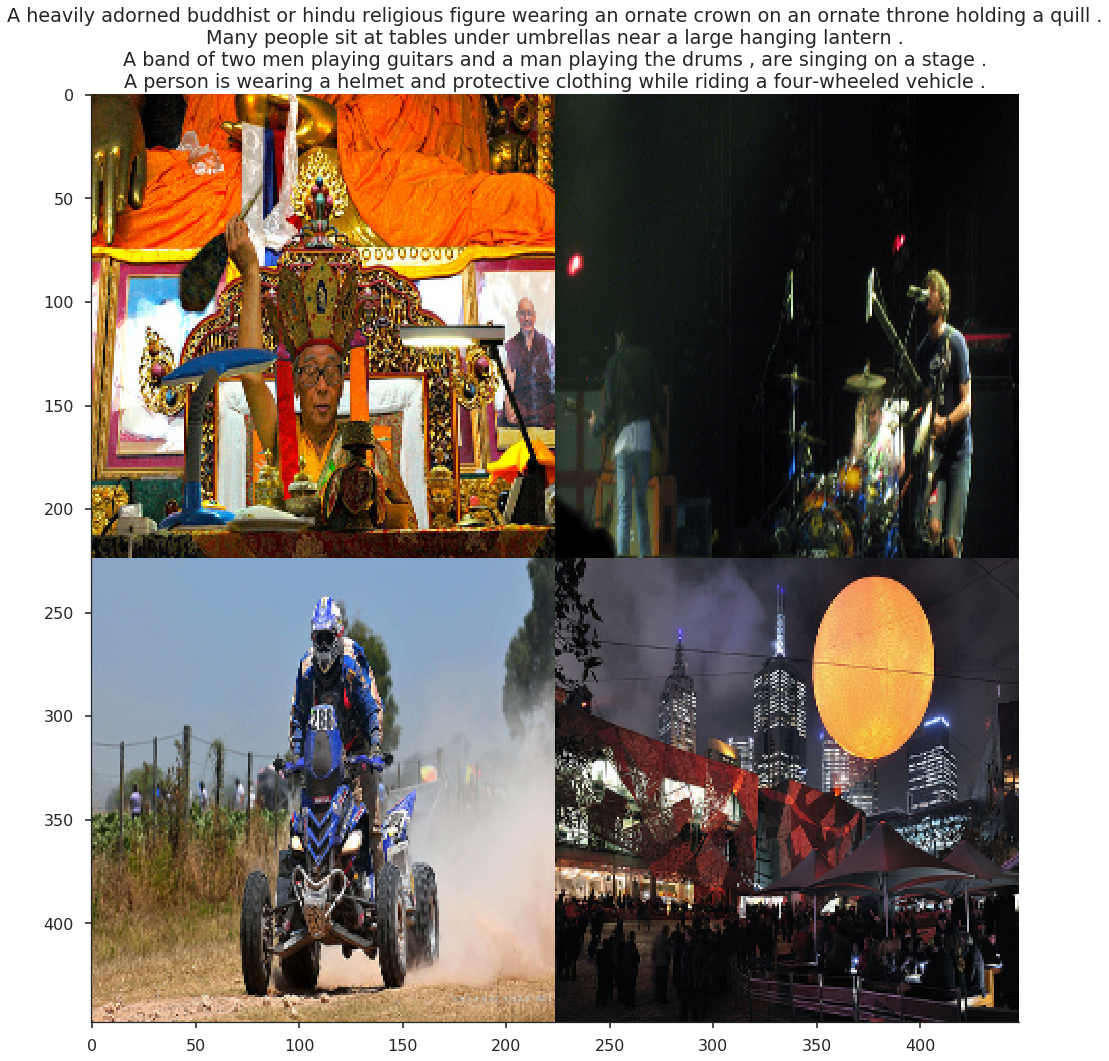

In [12]:
ax = plt.figure(figsize=(16, 16)).gca()
knn_ids = model.get_knn_images(doc='rock', k=4, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
fig_array = np.ones((2, 2, 224, 224, 3))
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    fig_array[i//2, i%2] = img

fig_array = fig_array.transpose(0, 2, 1, 3, 4).reshape(224*2, 224*2, 3)
ax.set_title('\n'.join(test_captions.loc[test_captions.fname.isin(knn.astype(str)), 'caption'].iloc[1::5]))
ax.imshow(fig_array)
sns.despine()
plt.tight_layout()

In [13]:
test_captions['fname'] = test_captions.fname.apply(lambda f: Path(f).name)
test_captions['fname']

0       2384507273.jpg
1       2384507273.jpg
2       2384507273.jpg
3       2384507273.jpg
4       2384507273.jpg
5       5352278538.jpg
             ...      
4994    4785739399.jpg
4995    3478471864.jpg
4996    3478471864.jpg
4997    3478471864.jpg
4998    3478471864.jpg
4999    3478471864.jpg
Name: fname, Length: 5000, dtype: object

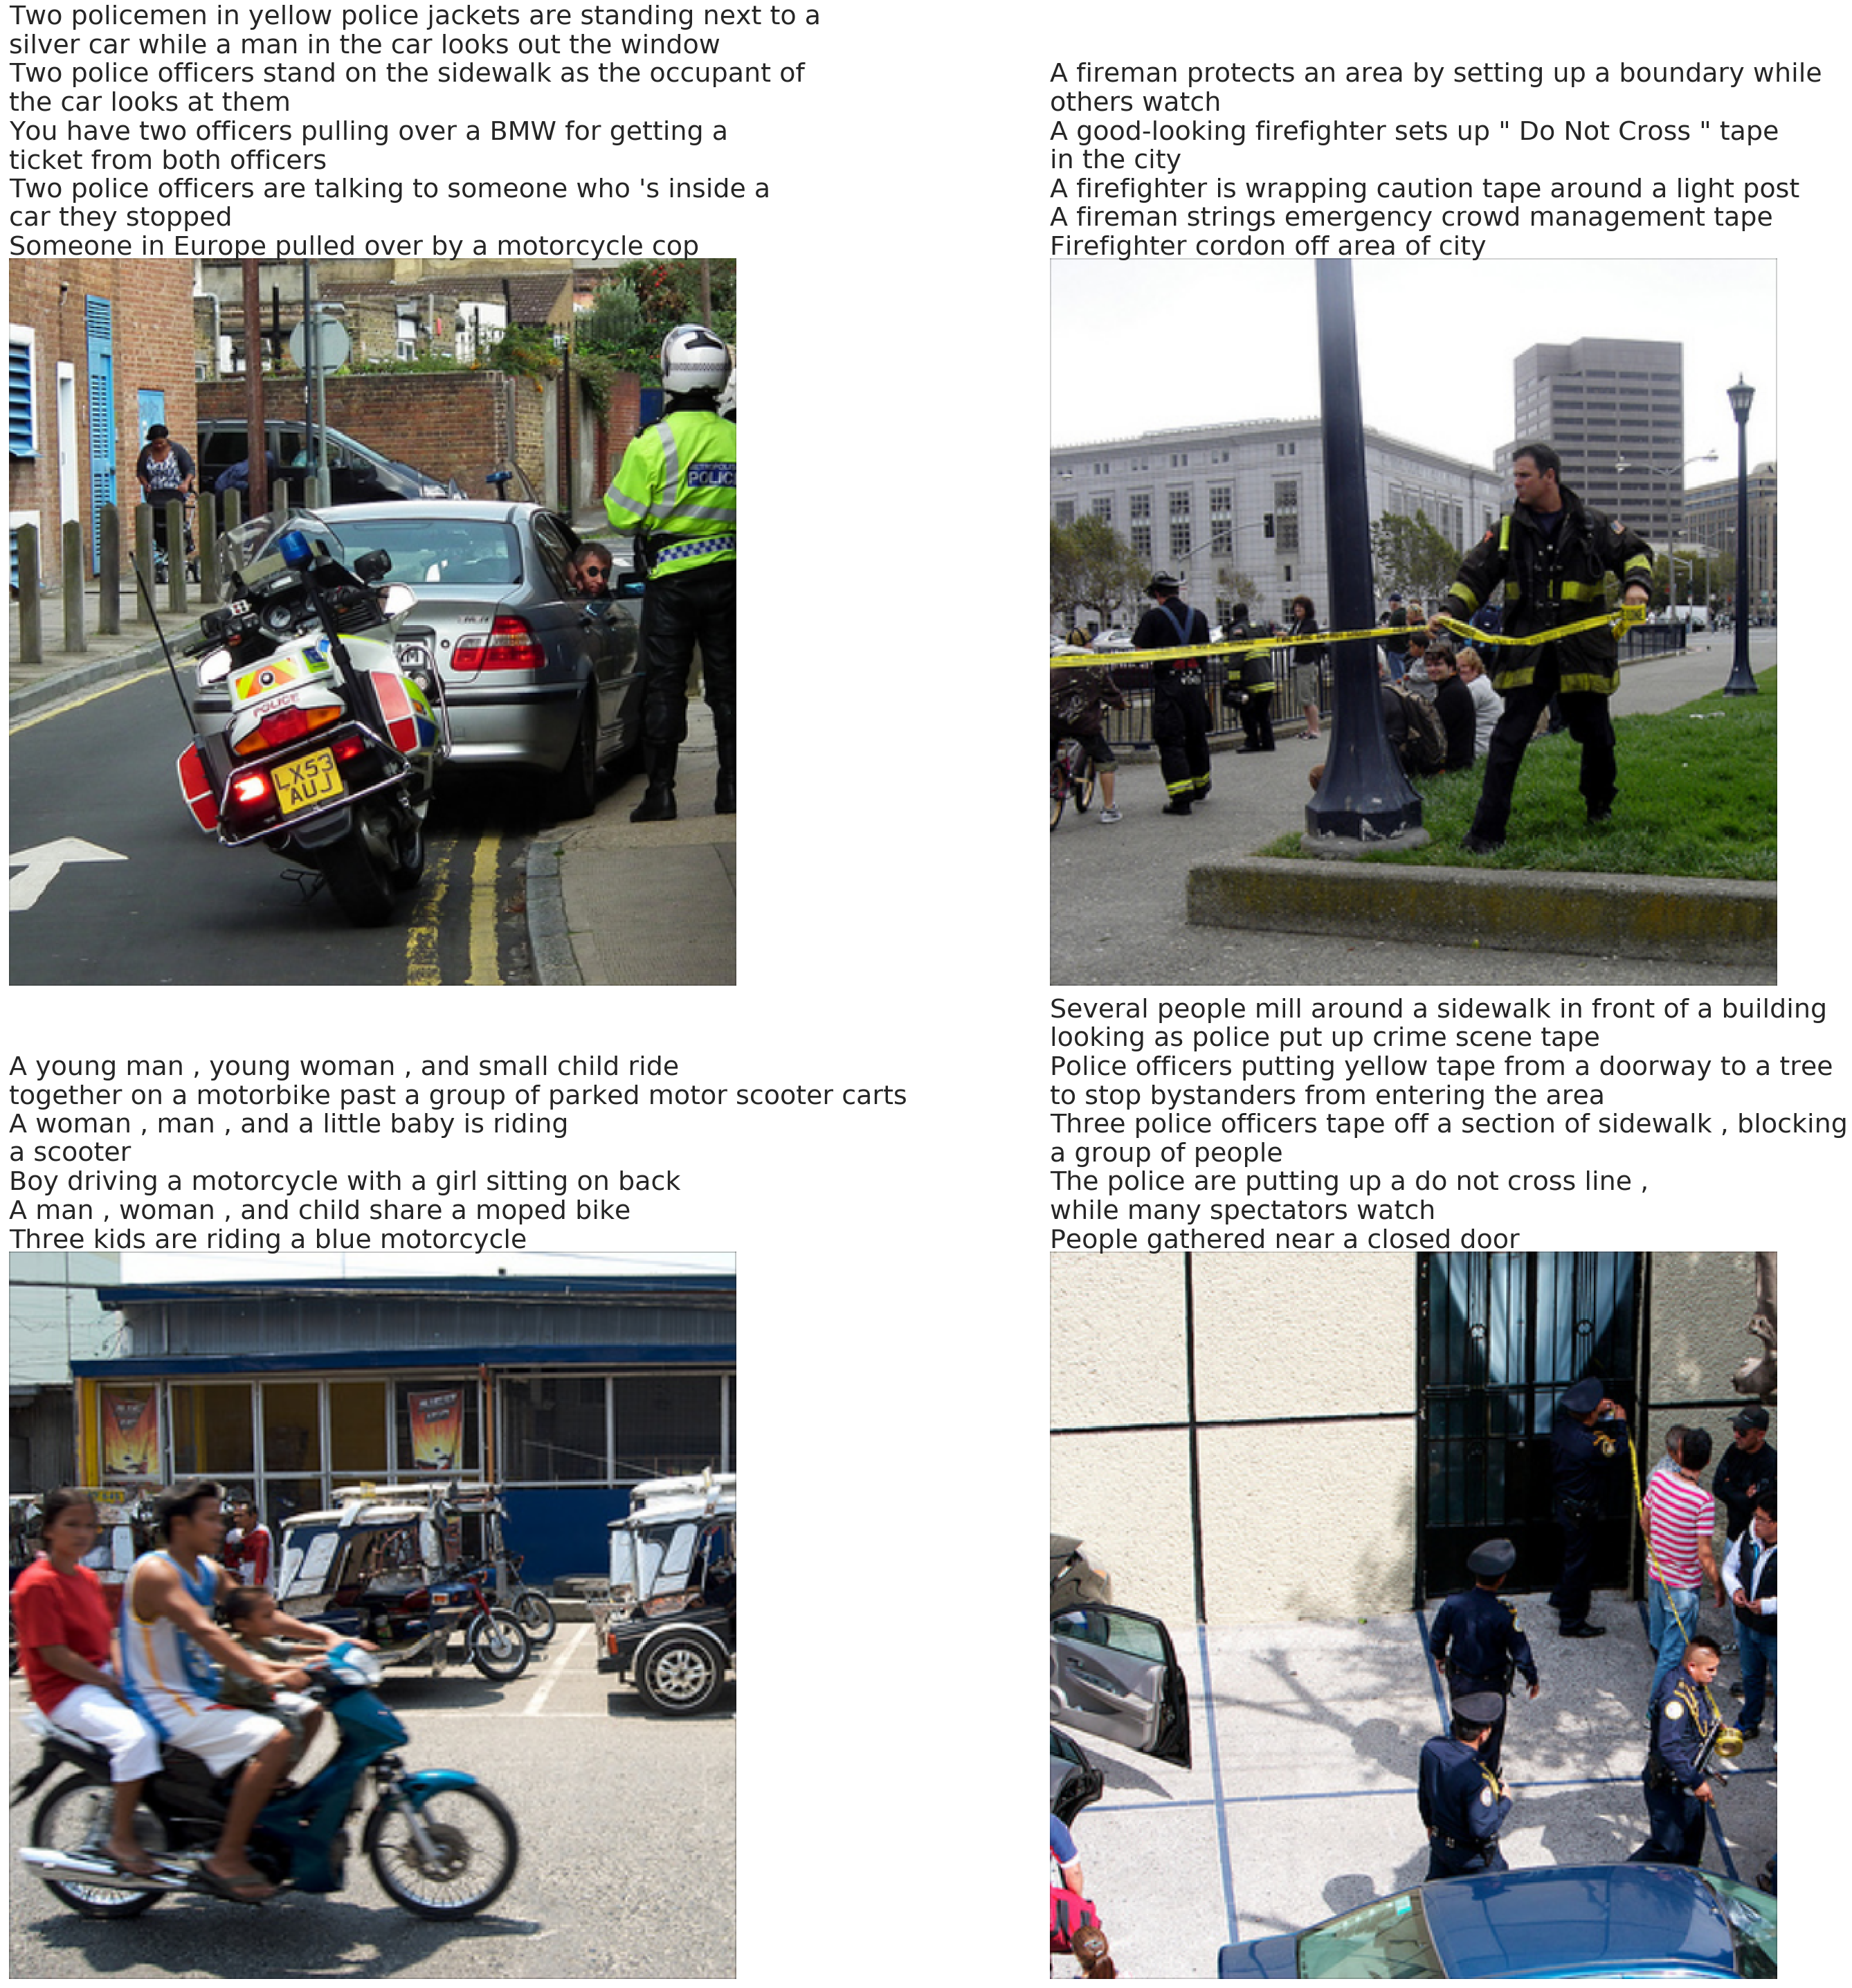

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(40, 40))
axes = axes.flatten()
knn_ids = model.get_knn_images(doc='street', k=16, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]

# knn_ids_no_street = [0, 1, 6, 7, 11, 14]
knn_ids_no_street = [0, 6, 7, 14]
title_max_len = 11
for ax, fname in zip(axes, knn[knn_ids_no_street]):
    fname = Path(fname)
    img = plt.imread(fname)
    img_shape_min = min(img.shape[:-1])
    img = resize(img[:img_shape_min, :img_shape_min], (512, 512), mode='constant')
    ax.imshow(img)
    ax.set_yticks([])
    ax.set_xticks([])
    titles = list(test_captions.loc[(test_captions.fname == fname.name), 'caption'])
    formatted_titles = []
    for title in titles:
        title = title.strip(".").strip()
        split_title = title.split()
        if len(split_title) > title_max_len:
            title = (f'{" ".join(split_title[:title_max_len])}\n'
                     f'{" ".join(split_title[title_max_len:])}')
        formatted_titles.append(title)
    ax.set_title('\n'.join(formatted_titles), size=38, loc='left')

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
results_sentences = {}
for i, row in tqdmn(test_captions.iterrows(), total=len(test_captions)):
    caption = row.caption
    fname = row.fname
    caption_id = row.caption_id
    knn_ids = model.get_knn_images(doc=caption, k=20, vec2img=vec2img_test)
    knn = vec2img_test.index[knn_ids]
    results_sentences[(fname, caption_id, caption)] = knn.copy()

In [27]:
import pickle

with open('results_sentences.pickle', 'wb') as fp:
    pickle.dump(results_sentences, fp)

In [2]:
import pickle

with open('results_sentences.pickle', 'rb') as fp:
    results_sentences = pickle.load(fp)

In [31]:
np.mean([1 if Path(fname).name in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0054

In [32]:
np.mean([1 if Path(fname).name in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0146

In [33]:
np.mean([1 if Path(fname).name in r[:5].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0296

In [34]:
np.mean([1 if Path(fname).name in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0518

In [35]:
np.mean([1 if Path(fname).name in r[:20].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0864